In [1]:
import pandas as pd
import numpy as np
import os
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sentence_transformers import SentenceTransformer
import hdbscan
import re
from info_gain import info_gain
import string
from sklearn.feature_extraction.text import CountVectorizer
import json
from sklearn import preprocessing

# Read Data

In [2]:
data_dir = r"C:\Users\LENOVO\Documents\Python\RedditData"

In [3]:
files = os.listdir(data_dir)

In [67]:
files

['reddit_data.csv',
 'reddit_stockmarket.csv',
 'reddit_stockmarket2021-02-18.csv',
 'reddit_stockmarket2021-02-22.csv',
 'reddit_stockmarket2021-02-26.csv',
 'reddit_stockmarket2021-03-02.csv',
 'reddit_stockmarket2021-03-06.csv',
 'reddit_stockmarket2021-03-10.csv',
 'reddit_stockmarket2021-03-14.csv',
 'reddit_stockmarket2021-03-18.csv',
 'reddit_stockmarket2021-03-22.csv',
 'reddit_stockmarket2021-03-26.csv',
 'reddit_stockmarket2021-05-10.csv',
 'reddit_stockmarket2021-05-11.csv',
 'reddit_stockmarket2021-05-13.csv',
 'reddit_stockmarket2021-05-16.csv',
 'reddit_stockmarket2021-05-17.csv',
 'reddit_stockmarket2021-05-19.csv',
 'reddit_stockmarket2021-05-21.csv',
 'reddit_stockmarket2021-05-23.csv',
 'reddit_stockmarket2021-05-25.csv',
 'reddit_stockmarket2021-05-27.csv',
 'reddit_stockmarket2021-05-29.csv',
 'reddit_stockmarket2021-05-31.csv',
 'reddit_stockmarket2021-06-02.csv',
 'reddit_stockmarket2021-06-04.csv',
 'reddit_stockmarket2021-06-06.csv',
 'reddit_stockmarket2021-06-

In [68]:
df_stock = []
df_wall = []
for file in files:
    if 'stock' in file:
        one_stock = pd.read_csv(os.path.join(data_dir, file),encoding='utf-8')
        df_stock.append(one_stock)
        
    elif 'wall' in file:
        one_wall = pd.read_csv(os.path.join(data_dir, file),encoding='utf-8')
        df_wall.append(one_wall)
    

# Pre-process

In [69]:
stock = pd.concat(df_stock)

In [70]:
wall = pd.concat(df_wall)

In [8]:
def pre_process(df):
    
    #drop duplicates
    df = df.drop_duplicates()
    
    #change data types
    df.created_utc = pd.to_datetime(df.created_utc)
    df.title = df.title.astype(str)
    df.selftext = df.selftext.astype(str)
    
    #concat title and selftext in order to obtain more information 
    df['concat'] = df['title']  + '. ' + df['selftext']
    df = df.reset_index()
    
    #clean data and delete links in the data
    df.concat = df.concat.apply(lambda x: x.replace('nan','').replace('\n','').replace('&amp;#x200B;',' ').replace('bcx9930','')
                                .replace('&gt;','')
                               .replace('&amp;',''))
    df.concat = df.concat.apply(lambda r: re.sub(r"http\S+", "", r))
    
    #return the concat text and date
    df_text = df[['concat', 'created_utc']].copy()
    
    return df_text

In [9]:
def split_doc(document, threshold):
    #split the document into words
    splitted_doc = document.split()
    #doc length
    length_original = len(splitted_doc)
    length = length_original
    n_groups = length // threshold
    n_words = length // (n_groups + 1) 
    s = ' '
    result = []
    i = 0
    while length > 0:
        if length >= n_words:
            new_doc = [splitted_doc[j] for j in range(i*n_words, i*n_words + n_words)]
            result.append(s.join(new_doc))
            length = length - n_words
        else:
            new_doc = [splitted_doc[j] for j in range(i*n_words, length_original)]
            result.append(s.join(new_doc))
            length = 0

        i = i + 1
    return result

In [10]:
def split_df(dataframe, threshold):

    index_list = []
    data = []
    for index, row in dataframe.iterrows():
        if len(row['concat'].split())>threshold:
            splitted_doc_list = split_doc(row['concat'], threshold)
            date = row['created_utc']
            for doc in splitted_doc_list:
                data.append({'concat': doc, 'created_utc': date})
            index_list.append(index)
    return index_list, data           
    

In [11]:
def split(df_text, threshold=200):
    
    index_list, data = split_df(df_text, threshold)
    df_text = df_text.drop(index_list)
    df_text = df_text.append(data, True)
    
    return df_text

In [12]:
def delete_short_doc(df_text, threshold=5):
    
    df_delete_index = df_text[df_text['concat'].apply(lambda r: len(r.split()))<threshold].index
    df_text = df_text.drop(df_delete_index)
    df_text = df_text.reset_index().drop('index', axis=1)
    
    return df_text

In [13]:
def process(df):
    return delete_short_doc(split(pre_process(df), 200), 5)

## Document Embeddings

In [14]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce GTX 1050 Ti


In [15]:
pre_df = wall

In [16]:
df = process(pre_df)

C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [17]:
model = SentenceTransformer('stsb-roberta-base-v2')
embeddings = model.encode(df.concat, show_progress_bar=True)

Batches:   0%|          | 0/993 [00:00<?, ?it/s]

In [18]:
embeddings.shape

(31754, 768)

## TF-IDF Functions

### Original TF-IDF calculation

In [19]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english",lowercase=True,tokenizer=lambda x: x.translate(str.maketrans('', '', string.punctuation)).split()).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

### New TF-IDF calculation

In [20]:
def c_tf_idf_new(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english",tokenizer=lambda x: x.translate(str.maketrans('', '', string.punctuation)).split()).fit(documents)
    t = count.transform(documents).toarray()
    max_f = t.max(axis=1)
    tf = np.divide(t.T, max_f)
    n_i = np.count_nonzero(t, axis=0)
    idf = np.log(np.divide(len(documents), n_i)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  


In [21]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

## Coherence

In [22]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import tokenize
from gensim.corpora import Dictionary

C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [23]:
def get_topic_words(df, cluster, new=True):
    
    #create the docs_df dataframe to store documents and their clusters
    docs_df = pd.DataFrame(df.concat.values, columns=["Doc"])
    docs_df['Topic'] = hdbscan_clusters.labels_
    docs_df['Doc_ID'] = range(len(docs_df))
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
    
    if new:
        tf_idf, count = c_tf_idf_new(docs_per_topic.Doc.values, m=len(df.values))
    else:
        tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(df.values))
        
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
    topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)
    
    return docs_df, top_n_words, topic_sizes

In [24]:
def get_coherence(docs_df, top_n_words):
    
    #function to assign the topic words to the dataframe
    def topic_words(topic_number):
        word_list =[]
        for t in top_n_words[topic_number]:
            word_list.append(t[0])
        return word_list
    
    #creating the words_df dataframe to store joined documents and topics
    clustered = docs_df[docs_df.Topic!=-1].copy()
    words_df = clustered.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
    words_df['Words']  = words_df['Topic'].apply(lambda r: topic_words(r))
    words_df['Altered']  = words_df['Doc'].apply(lambda r: r.translate(str.maketrans('', '', string.punctuation)).lower())
    docs = list(words_df['Altered'].apply(lambda r: r.split()).values)
    
    #create Dictionary from the documents
    not_known_word = False
    dic=Dictionary(docs)
    
    #create topic list
    topics = list(words_df['Words'].values)
    for idx,top in enumerate(topics):
        if -1 in dic.doc2idx(top):
            print(idx,dic.doc2idx(top))
            not_known_word = True
        
    
    #calculate coherence
    try:
        cm = CoherenceModel(topics=topics, coherence='c_v', dictionary=dic, texts=docs)
        coherence = cm.get_coherence()
    
        return coherence
    except:
        print("Error found.")

In [54]:
list_n_neighbours = [15, 30, 60, 90]
list_cluster_size = [15, 45, 75, 95]
list_samples = [1, 2, 15]

In [61]:
grid_result_stock_new = []
for nn in list_n_neighbours:
    for cs in list_cluster_size:
        for sa in list_samples:
                umap_embeddings = umap.UMAP(n_neighbors=nn, 
                                            n_components=15, 
                                            metric='cosine',
                                            min_dist=0.1,
                                            random_state=42).fit_transform(embeddings)
                hdbscan_clusters = hdbscan.HDBSCAN(min_cluster_size=cs,
                                          metric='euclidean',
                                          min_samples = int(cs/sa),                      
                                          cluster_selection_method='eom',
                                  #cluster_selection_epsilon=0.3,
                                          allow_single_cluster=False).fit(umap_embeddings)
                docs_df, top_n_words, topic_sizes = get_topic_words(df, hdbscan_clusters,True)
                co = get_coherence(docs_df, top_n_words)
                n_topics = len(top_n_words)
                n_noise = topic_sizes[topic_sizes['Topic']==-1].Size.values[0]
        
                print('n_topics: '+str(n_topics)+ 'n_noise: '+str(n_noise)+' n_neighbours: '+str(nn)+' min_cluster_size: '+str(cs)+  ' min_samples: '+ str(int(cs/sa))+' coherence: '+str(co))
                res_dic = {'n_topics': n_topics, 'n_noise': n_noise, 'n_neighbours': nn, 'min_cluster_size':cs, 'min_samples': int(cs/sa), 'coherence':co}
                grid_result_stock_new.append(res_dic)

C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


13 [2624, 1501, 1290, 1415, 1397, 6118, 26660, 32884, 4927, 30627, 28406, 32184, 21340, 31108, 38124, 38699, -1, 2898, 26375, 21494]
32 [4547, 889, 2157, 526, 7024, 21340, -1, 2898, 32884, 4927, 30627, 28406, 32184, 31108, 17724, 26660, -1, 26375, 21494, 31448]
39 [3112, 1567, 1434, 5261, 5263, 194, 1092, 5262, 1415, 21340, 32884, 4927, 30627, 28406, 32184, 26660, 31108, -1, 26375, 21494]
56 [2492, 2381, 1415, 527, 4396, 1475, 1290, 22667, 2898, 32884, 4927, 6118, 30627, 28406, 32184, 31448, 31108, 26660, -1, -1]
72 [6672, 6675, 6674, 487, 2117, 494, 6671, 504, 6673, 4396, 1414, 274, 1038, -1, 32184, 21340, 31108, 26660, 12154, 26375]
74 [6825, 3112, 6826, 194, 1415, 2376, 2208, 3118, 1812, 1530, 3499, 707, 4396, 436, 1507, 21340, 31108, 26660, 31448, -1]
172 [10922, 12886, 1952, 1177, 2066, 1200, 2450, 2068, 3490, 1197, 21340, 26375, 19459, -1, 31448, 2898, 32884, 21494, -1, 31108]
173 [12886, 10922, 1952, 1177, 2066, 9, 14, 1200, 7024, -1, 2898, 32884, 4927, 30627, 28406, 31108, 3218

C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


23 [3330, 2067, 706, 157, 527, 6802, 26424, 32296, 964, 30382, 21177, 31583, 21620, 31456, 37875, 38744, -1, 3799, 27184, 22373]
44 [4909, 1014, 1012, 493, 8867, 21620, -1, 3799, 32296, 964, 30382, 21177, 31583, 31456, 15932, 26424, -1, 27184, 22373, 35776]
58 [6117, 2245, 1846, 5691, 6116, 270, 907, 157, 6115, 21620, 32296, 964, 30382, 21177, 31583, 26424, 31456, -1, 27184, 22373]
75 [5982, 6805, 6806, 1918, 220, 71, 1332, 1138, 8867, 21177, 3799, 32296, 964, 30382, 21620, 31583, 31456, 26424, -1, 27184]
77 [266, 758, 157, 494, 4903, 1077, 706, 23341, 3799, 32296, 964, 6802, 30382, 21177, 31583, 35776, 31456, 26424, -1, -1]
105 [8406, 8407, 8408, 2327, 1745, 1410, 8405, 1053, 2901, 4903, 1717, 60, 148, -1, 31583, 21620, 31456, 26424, 13687, 27184]
106 [8409, 6117, 270, 8410, 157, 747, 1081, 4603, 2717, 2219, 4243, 618, 4903, 108, 236, 21620, 31456, 26424, 35776, -1]
126 [888, 5550, 2093, 1265, 1332, 62, 760, 21620, -1, 3799, 32296, 964, 30382, 21177, 31583, 8867, 31456, 26424, 20285, 

C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


1 [174, 179, 175, 170, 173, 176, 171, 157, 172, 13256, 33642, 1805, 32154, 26117, 33203, 25489, 29660, -1, 28867, 21969]
15 [1780, 1779, 714, 157, 535, 4886, 25489, 33642, 1805, 32154, 26117, 33203, 13256, 29660, 38833, 39016, -1, 3171, 28867, 21969]
21 [2184, 2186, 2187, 2188, 1818, 2000, 2183, 977, 2185, 2189, 1702, 60, 148, -1, 33203, 13256, 29660, 25489, 9332, 28867]
38 [4297, 4296, 4295, 1745, 4102, 4280, 981, 944, 255, 3771, 210, 124, 171, 349, 807, 657, 1620, 1805, -1, 21969]
101 [9057, 2213, 2151, 501, 15504, 13256, -1, 3171, 33642, 1805, 32154, 26117, 33203, 29660, 20388, 25489, -1, 28867, 21969, 36211]
109 [8677, 9509, 7527, 495, 192, 180, 3651, 186, 2360, 574, 13256, 28867, 18564, -1, 36211, 3171, 33642, 21969, -1, 29660]
110 [9509, 8677, 7527, 495, 192, 576, 2190, 180, 15504, -1, 3171, 33642, 1805, 32154, 26117, 29660, 33203, 13256, 20388, 25489]
154 [6480, 2111, 1780, 11455, 1779, 7326, 3279, 714, 157, 2969, 11457, 11456, 535, 9056, 763, 5080, 22691, 36211, 25489, -1]
201 

C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\umap\spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


16 [4744, 2134, 4747, 4745, 1178, 2183, 3055, 932, 687, 3906, 3461, 165, 4746, 2569, 178, -1, 32327, 19698, 26299, -1]
Error found.
n_topics: 167n_noise: 10272 n_neighbours: 15 min_cluster_size: 45 min_samples: 45 coherence: None


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


14 [4454, 65, 4455, 234, 858, 124, 2034, 1478, 862, 3157, 1038, 3088, 2235, 1154, 160, -1, 32341, 19111, 32474, -1]
Error found.
n_topics: 184n_noise: 9167 n_neighbours: 15 min_cluster_size: 45 min_samples: 22 coherence: None


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\umap\spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


30 [7250, 50, 7252, 7251, 710, 2265, 5761, 782, 590, 1377, 3574, 1268, 941, 382, 993, -1, 18374, 13218, 16956, -1]
Error found.
n_topics: 201n_noise: 8540 n_neighbours: 15 min_cluster_size: 45 min_samples: 3 coherence: None


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 73n_noise: 12606 n_neighbours: 15 min_cluster_size: 75 min_samples: 75 coherence: 0.42038208059411186


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\umap\spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 89n_noise: 13291 n_neighbours: 15 min_cluster_size: 75 min_samples: 37 coherence: 0.4137692084983062


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\umap\spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 94n_noise: 12460 n_neighbours: 15 min_cluster_size: 75 min_samples: 5 coherence: 0.41062987676660484


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\umap\spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 46n_noise: 16632 n_neighbours: 15 min_cluster_size: 95 min_samples: 95 coherence: 0.44573867494936453


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\umap\spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 55n_noise: 14874 n_neighbours: 15 min_cluster_size: 95 min_samples: 47 coherence: 0.42366270278589035


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 63n_noise: 12507 n_neighbours: 15 min_cluster_size: 95 min_samples: 6 coherence: 0.4211671073048854


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


18 [2354, 63, 1691, 578, 538, 6578, 17054, 28580, 5170, 24371, 28030, 32671, 14577, 27841, 12540, -1, 27609, 3455, 20699, 16689]
31 [3303, 3301, 3302, 1002, 728, 35, 1759, 733, 1646, 1100, 14577, 20699, -1, 30631, 27625, 3455, 28580, 16689, 27609, 27841]
75 [3303, 3302, 3301, 1002, 728, 3931, 1427, 315, -1, 30631, 3455, 28580, 5170, 24371, 28030, 8626, 32671, 3456, 27841, 17054]
77 [3301, 3303, 3302, 3929, 1002, 728, 880, 717, 8626, 24371, -1, 30631, 3455, 28580, 5170, 14577, 28030, 32671, 14273, 27841]
219 [15421, 15418, 15419, 15420, 8728, 1409, 288, 659, 13817, 71, 20699, 32671, 14577, 27841, 17054, 27609, -1, 16689, 27625, 33372]
317 [5718, 5564, 9845, 788, 3616, 753, 2123, 1511, 978, 1163, 24371, 6578, 28030, 32671, -1, 14577, 28580, 27841, 17054, 27609]
Error found.
n_topics: 645n_noise: 4467 n_neighbours: 30 min_cluster_size: 15 min_samples: 15 coherence: None


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


32 [3845, 42, 639, 14, 939, 8159, 14563, 28392, 5737, 24897, 28299, 32349, 15213, 29380, 13344, -1, 28210, 2960, 22008, 16490]
263 [16077, 16074, 16075, 16076, 9691, 980, 686, 1370, 14515, 48, 22008, 32349, 15213, 29380, 14563, 28210, -1, 16490, 28030, 35111]
360 [7605, 7293, 9046, 1832, 4656, 1936, 2126, 15, 285, 113, 24897, 8159, 28299, 32349, -1, 15213, 28392, 29380, 14563, 28210]
Error found.
n_topics: 734n_noise: 3563 n_neighbours: 30 min_cluster_size: 15 min_samples: 7 coherence: None


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


53 [1950, 932, 309, 705, 666, 10131, 16243, 30017, 4911, 26108, 30248, 33120, 16603, 31435, 13653, -1, 30075, 4556, 23995, 16960]
203 [12712, 12708, 12710, 12711, 9992, 718, 784, 365, 12709, 93, 23995, 33120, 16603, 31435, 16243, 30075, -1, 16960, 29572, 35134]
383 [4506, 8368, 13984, 2690, 6030, 2781, 880, 915, 1304, 195, 26108, 10131, 30248, 33120, -1, 16603, 30017, 31435, 16243, 30075]
Error found.
n_topics: 766n_noise: 3809 n_neighbours: 30 min_cluster_size: 15 min_samples: 1 coherence: None


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 144n_noise: 11828 n_neighbours: 30 min_cluster_size: 45 min_samples: 45 coherence: 0.4344700593572625


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 169n_noise: 11281 n_neighbours: 30 min_cluster_size: 45 min_samples: 22 coherence: 0.42351927866451333


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 189n_noise: 10038 n_neighbours: 30 min_cluster_size: 45 min_samples: 3 coherence: 0.4158740606068862


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 64n_noise: 14802 n_neighbours: 30 min_cluster_size: 75 min_samples: 75 coherence: 0.4095634339986938


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 71n_noise: 13005 n_neighbours: 30 min_cluster_size: 75 min_samples: 37 coherence: 0.3983457591763819


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 85n_noise: 12223 n_neighbours: 30 min_cluster_size: 75 min_samples: 5 coherence: 0.41420142069122595


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 43n_noise: 16501 n_neighbours: 30 min_cluster_size: 95 min_samples: 95 coherence: 0.41547385630714134


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 47n_noise: 14671 n_neighbours: 30 min_cluster_size: 95 min_samples: 47 coherence: 0.4113396424973159


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 56n_noise: 13010 n_neighbours: 30 min_cluster_size: 95 min_samples: 6 coherence: 0.4122138524806793


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


10 [1661, 1295, 1050, 753, 143, 8794, 15158, 28736, 2224, 22230, 31692, 27737, 13172, 27431, 4120, -1, 14641, 2329, 21410, 19943]
50 [5010, 5009, 5008, 2294, 2006, 863, 864, 319, -1, 24077, 2329, 28736, 2224, 22230, 31692, -1, 27737, 10959, 27431, 15158]
60 [5563, 1978, 753, 1222, 3400, 1265, 1050, -1, 2329, 28736, 2224, 8794, 22230, 31692, 27737, 27058, 27431, 15158, 24077, 14641]
72 [5008, 5010, 5009, 613, 2006, 2294, 1089, 856, -1, 22230, -1, 24077, 2329, 28736, 2224, 13172, 31692, 27737, 12286, 27431]
75 [3585, 2245, 1974, 6557, 130, 2348, -1, 28736, 2224, 22230, 31692, 27737, 13172, 27431, 14641, 15158, 24077, 21410, 19943, 27058]
173 [5010, 5008, 5009, 2294, 2006, 512, 2284, 2295, 1362, 2191, 13172, 21410, -1, 24077, 27058, 2329, 28736, 19943, 14641, 27431]
244 [8951, 6412, 5583, 6501, 4107, 594, 1302, 1108, 936, 1400, 2180, 345, 22007, 14641, 22230, -1, 31692, 27737, 13172, 27431]
365 [2581, 398, 1305, 1089, 3554, 13599, 3146, 238, 860, 753, 22230, -1, 2329, 27058, 19943, 28736,

C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


19 [2567, 1032, 1368, 410, 383, 7367, 15710, 31161, 2774, 22152, 30801, 29267, 13198, 27453, 4335, -1, 14965, 122, 21598, 20750]
78 [6198, 2375, 410, 1598, 681, 1189, 1368, -1, 122, 31161, 2774, 7367, 22152, 30801, 29267, 27076, 27453, 15710, 24068, 14965]
270 [9341, 7312, 5583, 5221, 4323, 350, 1040, 242, 558, 1855, 2728, 258, 26290, 14965, 22152, -1, 30801, 29267, 13198, 27453]
410 [2830, 960, 1043, 1543, 3859, 14059, 890, 3630, 1025, 410, 22152, -1, 122, 27076, 20750, 31161, 2774, 14965, 15710, 21598]
468 [23832, 597, 70, 4876, 9443, 480, 23834, 23833, 1095, 681, 1842, 1220, 599, 27453, 22152, 30801, 4335, 29267, 13198, -1]
Error found.
n_topics: 729n_noise: 3986 n_neighbours: 60 min_cluster_size: 15 min_samples: 7 coherence: None


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


28 [2729, 19, 734, 147, 497, 3732, 16159, 31368, 4565, 22709, 27338, 28293, 14949, 27865, 5931, -1, 16425, 264, 23714, 21273]
92 [7270, 2938, 147, 1411, 2344, 687, 734, -1, 264, 31368, 4565, 3732, 22709, 27338, 28293, 27490, 27865, 16159, 25158, 16425]
290 [5263, 936, 16041, 5871, 16042, 3301, 16043, 3581, 1449, 2597, 23714, 22709, 25487, 25158, 264, 31368, 4565, -1, 27338, 16425]
294 [9579, 7231, 8446, 2940, 5921, 126, 36, 373, 704, 2644, 1842, 388, 26780, 16425, 22709, -1, 27338, 28293, 14949, 27865]
469 [3565, 1629, 41, 1338, 5732, 14815, 1569, 5160, 7, 147, 22709, -1, 264, 27490, 21273, 31368, 4565, 16425, 16159, 23714]
505 [24588, 2296, 215, 6511, 8484, 890, 24590, 24589, 128, 2344, 1709, 1272, 574, 27865, 22709, 27338, 5931, 28293, 14949, -1]
Error found.
n_topics: 762n_noise: 3833 n_neighbours: 60 min_cluster_size: 15 min_samples: 1 coherence: None


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 142n_noise: 11308 n_neighbours: 60 min_cluster_size: 45 min_samples: 45 coherence: 0.44362856369173287


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 163n_noise: 9947 n_neighbours: 60 min_cluster_size: 45 min_samples: 22 coherence: 0.4429094760542384


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 198n_noise: 9389 n_neighbours: 60 min_cluster_size: 45 min_samples: 3 coherence: 0.43455268720970397


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 58n_noise: 16017 n_neighbours: 60 min_cluster_size: 75 min_samples: 75 coherence: 0.4349767886178307


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 69n_noise: 14041 n_neighbours: 60 min_cluster_size: 75 min_samples: 37 coherence: 0.4364402500266907


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 83n_noise: 12542 n_neighbours: 60 min_cluster_size: 75 min_samples: 5 coherence: 0.4335824547394682


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 38n_noise: 16402 n_neighbours: 60 min_cluster_size: 95 min_samples: 95 coherence: 0.4430088828370783


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 44n_noise: 15171 n_neighbours: 60 min_cluster_size: 95 min_samples: 47 coherence: 0.4185453544873747


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 57n_noise: 13151 n_neighbours: 60 min_cluster_size: 95 min_samples: 6 coherence: 0.412719570687974


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


18 [2677, 2679, 2678, 1027, 1596, 1520, 1243, 639, -1, 22157, -1, 23714, 2267, 28331, 3182, 12493, 31203, 30119, 9388, 25653]
36 [2679, 2677, 2678, 1596, 1520, 199, 1833, 2416, 2681, 1817, 12493, 24796, -1, 23714, 25597, 2267, 28331, 16628, 15121, 25653]
46 [4535, 1850, 1208, 778, 182, 12492, 17223, 28331, 3182, 22157, 31203, 30119, 12493, 25653, 3011, -1, 15121, 2267, 24796, 16628]
70 [2679, 2678, 2677, 1596, 1520, 648, 1030, 398, -1, 23714, 2267, 28331, 3182, 22157, 31203, -1, 30119, 9005, 25653, 17223]
95 [7399, 1571, 778, 760, 2209, 1412, 1208, -1, 2267, 28331, 3182, 12492, 22157, 31203, 30119, 25597, 25653, 17223, 23714, 15121]
96 [7364, 7365, 4019, 1573, 2998, 165, 660, 1259, 1103, 1921, 1787, 129, 21722, 15121, 22157, -1, 31203, 30119, 12493, 25653]
173 [1012, 3202, 727, 166, 11855, 2840, -1, 28331, 3182, 22157, 31203, 30119, 12493, 25653, 15121, 17223, 23714, 24796, 16628, 25597]
352 [2206, 494, 2236, 1243, 936, 13866, 311, 1845, 13, 778, 22157, -1, 2267, 25597, 16628, 28331, 3

C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


57 [4735, 2152, 706, 1030, 206, 10892, 17435, 27293, 3242, 37962, 29006, 28534, 12984, 25367, 3775, -1, 15163, 2356, 24579, 17135]
112 [7888, 1767, 1030, 757, 2308, 1451, 706, -1, 2356, 27293, 3242, 10892, 37962, 29006, 28534, 26240, 25367, 17435, 24163, 15163]
114 [7853, 7854, 4036, 1769, 3767, 191, 937, 1297, 1144, 2197, 1962, 156, 23238, 15163, 37962, -1, 29006, 28534, 12984, 25367]
394 [2305, 516, 2785, 1280, 1472, 14466, 334, 2148, 45, 1030, 37962, -1, 2356, 26240, 17135, 27293, 3242, 15163, 17435, 24579]
Error found.
n_topics: 720n_noise: 4092 n_neighbours: 90 min_cluster_size: 15 min_samples: 7 coherence: None


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


16 [2174, 1367, 1449, 14, 711, 12084, 19686, 28708, 2229, 38350, 29875, 30152, 13693, 25378, -1, -1, 16772, 1047, 26066, 19333]
54 [4502, 4492, 4499, 1552, 997, 144, 985, 999, 2449, 978, 13693, 26066, -1, 24951, 27177, 1047, 28708, 19333, 16772, 25378]
59 [5264, 5265, 1219, 2149, 5038, 679, 176, 1106, 401, 1242, 723, 80, 15523, 16772, 38350, -1, 29875, 30152, 13693, 25378]
82 [4502, 4499, 4492, 1552, 997, 157, 988, 549, -1, 24951, 1047, 28708, 2229, 38350, 29875, 3721, 30152, 10778, 25378, 19686]
95 [7156, 7157, 2174, 3416, 6885, 1367, 711, 1449, 721, 3406, 14, 3414, 425, 27177, 13693, -1, 12084, 38350, 29875, 30152]
133 [9059, 1497, 14, 317, 15, 1761, 1449, -1, 1047, 28708, 2229, 12084, 38350, 29875, 30152, 27177, 25378, 19686, 24951, 16772]
250 [2844, 5827, 1053, 225, 1502, 919, 80, 13693, 24951, 1047, 28708, 2229, 38350, 29875, 30152, 3721, 25378, 19686, -1, 26066]
424 [0, 2402, 1628, 1889, 2921, 15917, 5, 2985, 774, 14, 38350, -1, 1047, 27177, 19333, 28708, 2229, 16772, 19686, 2606

C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 133n_noise: 11978 n_neighbours: 90 min_cluster_size: 45 min_samples: 45 coherence: 0.4445408644339804


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 158n_noise: 10843 n_neighbours: 90 min_cluster_size: 45 min_samples: 22 coherence: 0.4414760607097445


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 187n_noise: 9881 n_neighbours: 90 min_cluster_size: 45 min_samples: 3 coherence: 0.4303700230634606


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 55n_noise: 15434 n_neighbours: 90 min_cluster_size: 75 min_samples: 75 coherence: 0.4478964795303924


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 66n_noise: 13394 n_neighbours: 90 min_cluster_size: 75 min_samples: 37 coherence: 0.4327809477891322


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 81n_noise: 12160 n_neighbours: 90 min_cluster_size: 75 min_samples: 5 coherence: 0.4218350513594144


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 39n_noise: 17128 n_neighbours: 90 min_cluster_size: 95 min_samples: 95 coherence: 0.43851487103656833


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 52n_noise: 14643 n_neighbours: 90 min_cluster_size: 95 min_samples: 47 coherence: 0.4262073401795065


C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


n_topics: 60n_noise: 13269 n_neighbours: 90 min_cluster_size: 95 min_samples: 6 coherence: 0.4153975172981252


### Read in coherence results

'grid_result_large.csv'- wallstreetbets grid search results <br>
'grid_result_large_stock.csv' - stockmarket grid search results <br>
'grid_result_large_stock_new.csv' - stockmarket with new tf-idf calculation

In [61]:
co_df = pd.read_csv('grid_result_large_stock.csv')

In [62]:
df_sort = co_df.sort_values(['coherence'],ascending=[False])

In [64]:
no_nan = df_sort[(~np.isnan(df_sort['coherence']))]
x = no_nan[['n_topics','n_noise','coherence']].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_norm = pd.DataFrame(x_scaled)

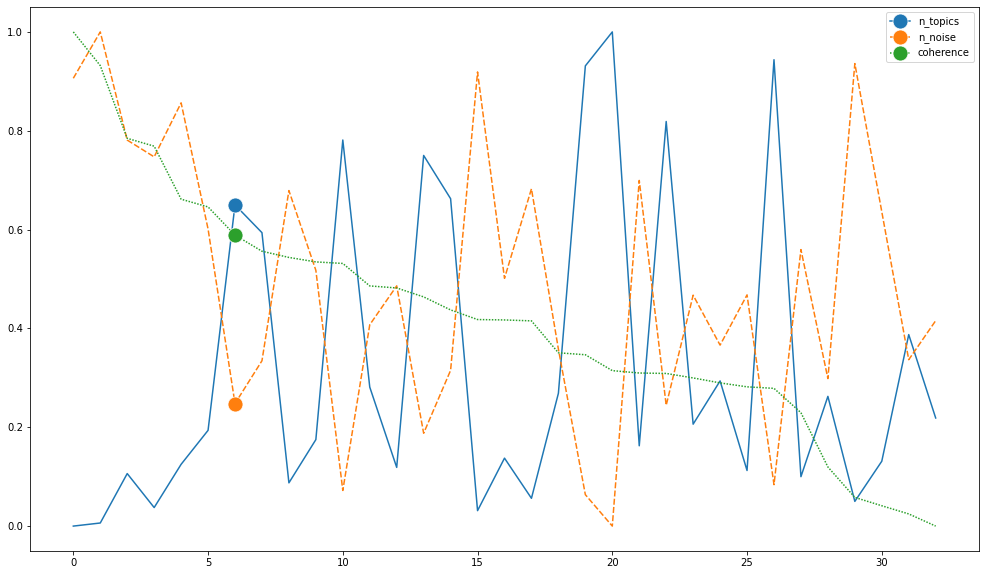

In [68]:
fig, ax = plt.subplots(figsize=(17, 10))
ax = sns.lineplot(data=df_norm, marker='o', markevery=[6], markersize=15)
ax.legend(['n_topics','n_noise','coherence'])

# Over Time

### Parameters

In [25]:
#wallstreetbets
n_neighbours = 60
min_cluster_size = 45
min_samples = 3

### UMAP

In [26]:
umap_embeddings = umap.UMAP(n_neighbors=n_neighbours, 
                            n_components=15, 
                            metric='cosine',
                            min_dist=0.1,
                            random_state=42).fit_transform(embeddings)

### HDBSCAN

In [27]:
hdbscan_clusters = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                          metric='euclidean',
                          min_samples = min_samples,                      
                          cluster_selection_method='eom',
                          #cluster_selection_epsilon=0.3,
                          allow_single_cluster=False).fit(umap_embeddings)

In [28]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=60, n_components=2, metric='cosine', min_dist=0.2, random_state=42).fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = hdbscan_clusters.labels_

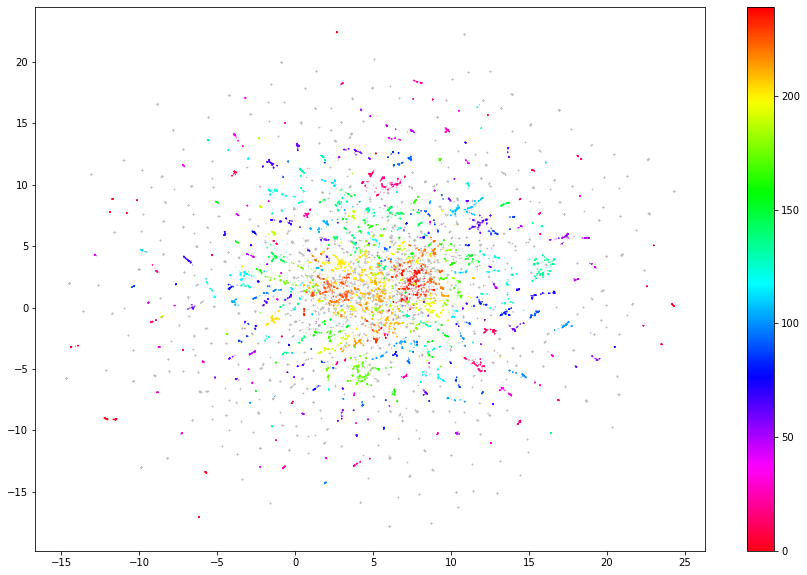

In [29]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(15, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

### TF-IDF

In [30]:
docs_df = pd.DataFrame(df.concat.values, columns=["Doc"])
docs_df['Topic'] = hdbscan_clusters.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [31]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(df.values))
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


,Topic,Size
0,-1,10274
202,201,436
63,62,381
197,196,321
127,126,274
211,210,268
173,172,256
226,225,246
118,117,243
238,237,210


In [32]:
len(topic_sizes)

241

In [33]:
docs_df['created_utc'] = df.created_utc

In [34]:
topic_indecies = topic_sizes.index

In [35]:
topic_indecies = topic_indecies - 1

In [36]:
for i in topic_indecies[0:10]:
    print(i,top_n_words[i][0:5])

-1 [('best', 0.006361533610466484), ('market', 0.006004959035722819), ('company', 0.005993062981380321), ('short', 0.005562220145943429), ('like', 0.005538588235263884)]
201 [('cannabis', 0.04781555503590969), ('tilray', 0.02735258972361732), ('weed', 0.02614879159688265), ('medical', 0.017258217685812323), ('marijuana', 0.016050093659531556)]
62 [('blackberry', 0.0687326298694677), ('bb', 0.042135937913927585), ('qnx', 0.033189338014496035), ('software', 0.03136248705940425), ('security', 0.01957152549070699)]
196 [('lose', 0.015357295087013514), ('dont', 0.01403948102132798), ('know', 0.012998357828773304), ('im', 0.012603308087284505), ('just', 0.012365195755411918)]
126 [('hands', 0.036416989759919645), ('class', 0.03057025537523421), ('animal', 0.02765283042589024), ('diamond', 0.026558080629688615), ('uwmc', 0.02605948229829115)]
210 [('dd', 0.03732198702821299), ('post', 0.01870164563396642), ('redditcom', 0.017155056240526354), ('im', 0.01615556650541571), ('rkt', 0.01549428153

In [37]:
def topic_words(topic_number):
    word_list =[]
    for t in top_n_words[topic_number]:
        word_list.append(t[0])
    return word_list

In [38]:
topic_words(46)[0:10]

['otc',
 'puts',
 'float',
 'position',
 'value',
 'trades',
 'citadel',
 'volume',
 'tehe',
 'r']

In [39]:
topic_indecies

Int64Index([ -1, 201,  62, 196, 126, 210, 172, 225, 117, 237,
            ...
             32, 231, 120, 188,  89,  14,  42, 107,  56,   7],
           dtype='int64', length=241)

In [41]:
clustered['date'] = clustered.created_utc.dt.date

<AxesSubplot:xlabel='created_utc', ylabel='Count'>

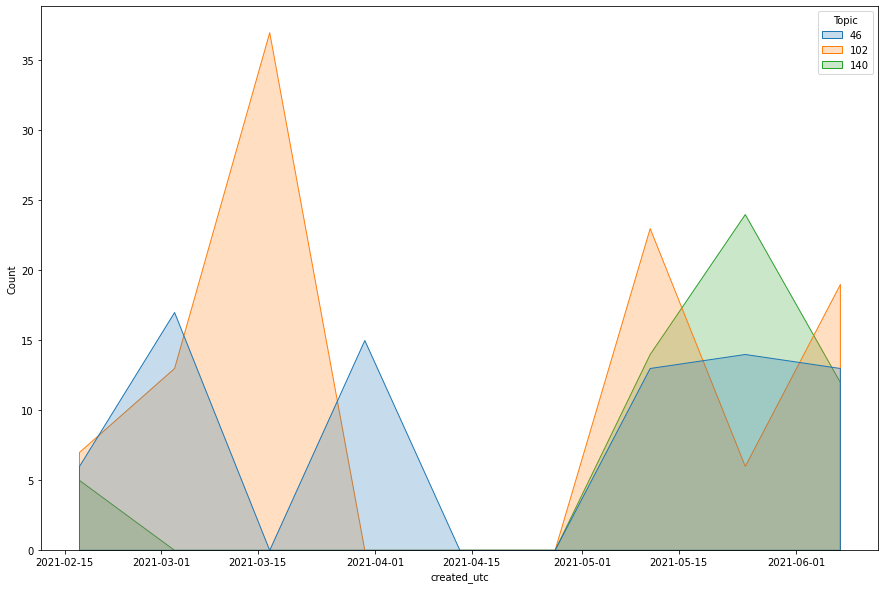

In [42]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(data = clustered, x='created_utc', hue='Topic',palette='tab10',element="poly")

In [43]:
clustered = docs_df[docs_df.Topic.isin(topic_indecies[1:20])].copy()

In [44]:
clustered['date'] = clustered.created_utc.dt.date

In [45]:
topic_df = clustered[['Topic','date','Doc_ID']].groupby(['Topic', 'date'], as_index = False).count()

In [46]:
idx = topic_df.groupby(['Topic'])['Doc_ID'].transform(max) == topic_df['Doc_ID']

In [47]:
topic_max = topic_df[idx]

In [48]:
topic_max = topic_max.rename(columns={'Doc_ID': 'count'})

In [49]:
topic_max = topic_max.sort_values(by=['date','count'],ascending=[True,False])

In [50]:
topic_max=topic_max.reset_index()

In [51]:
topic_max = topic_max.drop('index',axis=1)

In [52]:
topic_max

,Topic,date,count
0,201,2021-02-11,43
1,211,2021-02-14,14
2,237,2021-02-18,25
3,25,2021-02-18,24
4,126,2021-02-26,20
5,203,2021-02-26,20
6,211,2021-03-02,14
7,196,2021-03-06,33
8,213,2021-03-06,19
9,126,2021-03-10,20


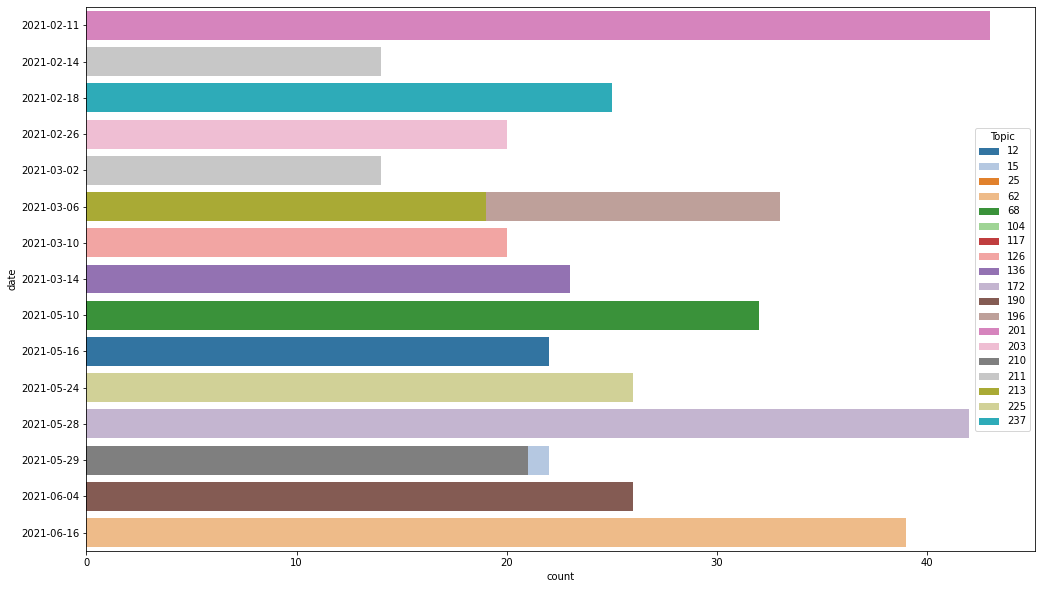

In [53]:
fig, ax = plt.subplots(figsize=(17, 10))
ax = sns.barplot(y="date", x="count", data=topic_max, hue='Topic', palette='tab20',dodge=False, orient='h')

In [55]:
top_n_words[117]

[('amc', 0.042763045558342185),
 ('viac', 0.03761715988893069),
 ('ape', 0.01797887946016663),
 ('rebm', 0.017415030697153954),
 ('calls', 0.01587507119314257),
 ('ingredion', 0.014839830652959737),
 ('gme', 0.013968985142256439),
 ('flag', 0.013736924245957694),
 ('tight', 0.013443239897088536),
 ('understand', 0.012362148695228807),
 ('apes', 0.01207154168682023),
 ('posts', 0.011619224990054848),
 ('pfof', 0.011366939499402798),
 ('play', 0.01106752115212845),
 ('thank', 0.011009680447777921),
 ('nuked', 0.010681595236404788),
 ('stock', 0.010525792574320424),
 ('volume', 0.01046455275485839),
 ('taste', 0.010454394025505137),
 ('dark', 0.010365647873382532)]

<AxesSubplot:xlabel='created_utc', ylabel='Count'>

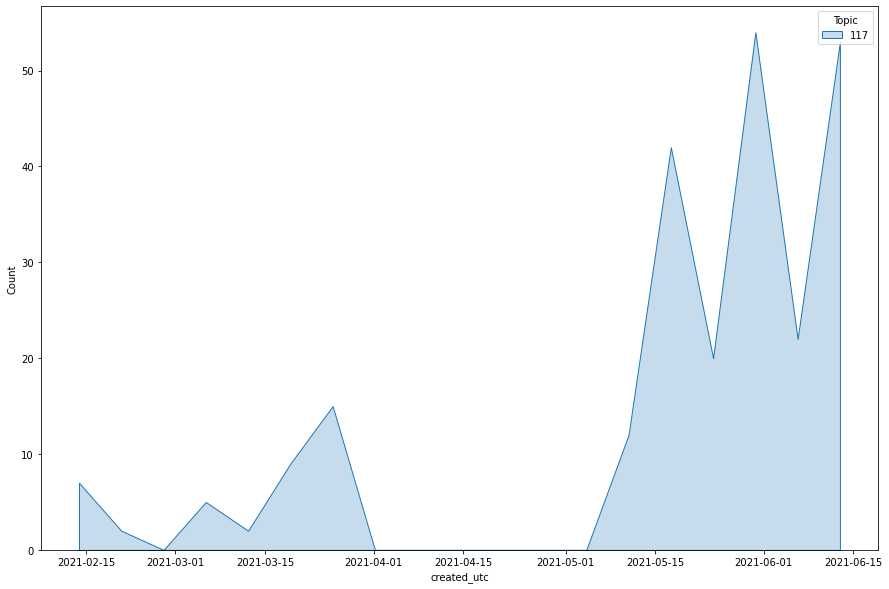

In [56]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(data = clustered[clustered['Topic']==117], x='created_utc', hue='Topic',palette='tab10',element="poly")

## Read new data

In [57]:
new_data_dir = r"C:\Users\LENOVO\Documents\Python\new reddit"

In [58]:
new_files = os.listdir(new_data_dir)

In [59]:
new_files

['reddit_wallstreetbets2021-06-18.csv']

In [65]:
new_df_wall = []
for file in new_files:
    if 'stock' in file:
        one_stock_df = pd.read_csv(os.path.join(new_data_dir, file),encoding='utf-8')
        new_df_stock.append(one_stock_df)
        
    elif 'wall' in file:
        one_wall_df = pd.read_csv(os.path.join(new_data_dir, file),encoding='utf-8')
        new_df_wall.append(one_wall_df)

In [66]:
new_df_wall[0]

,created_utc,downs,id,kind,link_flair_css_class,score,selftext,subreddit,title,ups,upvote_ratio
0,2021-06-18T16:58:07Z,0.0,o2r0mi,t3,dd,1.0,Hedge funds have researchers to pull this info...,wallstreetbets,Blackberry QNX Software MOADD!!!,1.0,1.00
1,2021-06-18T16:55:32Z,0.0,o2qyom,t3,yolo,31.0,NaN,wallstreetbets,Gave my baby brother $2000 6 months ago. My me...,31.0,0.97
2,2021-06-18T16:53:25Z,0.0,o2qx1d,t3,profit,27.0,NaN,wallstreetbets,WISH 🚀🚀🚀 LFG $12.5c 😝,27.0,0.88
3,2021-06-18T16:49:21Z,0.0,o2qttr,t3,loss,21.0,NaN,wallstreetbets,"WKHS CLNE Loss. Holding shares for now, but op...",21.0,0.96
4,2021-06-18T16:42:24Z,0.0,o2qokt,t3,loss,27.0,NaN,wallstreetbets,I still have time lol😂,27.0,0.83
...,...,...,...,...,...,...,...,...,...,...,...
995,2021-06-17T20:22:52Z,0.0,o23yon,t3,question,0.0,Federal government just announced that they wi...,wallstreetbets,ATEA pharmaceuticals (AVIR),0.0,0.27
996,2021-06-17T20:09:12Z,0.0,o23n6f,t3,question,9.0,Many people believe inflation is here. I perso...,wallstreetbets,How to play inflation without exposing yoursel...,9.0,0.62
997,2021-06-17T20:05:32Z,0.0,o23k4e,t3,dd,116.0,The one thing holding Canoo back was their lac...,wallstreetbets,Canoo ($GOEV) Manufacturing Announcement Solid...,116.0,0.75
998,2021-06-17T19:57:56Z,0.0,o23dge,t3,dd,15.0,Green energy investing is all the rage these d...,wallstreetbets,$PLUG. Plug Power Plugging Away at Improving H...,15.0,0.60


In [71]:
wall

,created_utc,downs,id,kind,link_flair_css_class,score,selftext,subreddit,title,ups,upvote_ratio
0,2021-02-15T15:30:12Z,0.0,lker56,t3,dd,10.0,"Listen up, idiots. Do your own research. Here ...",wallstreetbets,"Some Quick DD on UCTT (Ultra Clean Holdings, I...",10.0,0.71
1,2021-02-15T15:28:57Z,0.0,lkeqb3,t3,meme,577.0,NaN,wallstreetbets,"When a CNBC anchor asks, ""Is the Reddit Army g...",577.0,0.97
2,2021-02-15T15:10:32Z,0.0,lkeej1,t3,chart,275.0,NaN,wallstreetbets,Weekend Discussion,275.0,0.96
3,2021-02-15T15:10:30Z,0.0,lkeeie,t3,question,16.0,I was reading OPs DD [HERE](https://www.reddit...,wallstreetbets,My UK Plays for the Oil Boom because I can't Y...,16.0,0.74
4,2021-02-15T14:38:33Z,0.0,lkdu3w,t3,dd,33.0,LEGITIMATE ARGUMENT TO INVEST IN CANNABIS (Sho...,wallstreetbets,Cannabis Stocks are Going BONGkers Ultimate DD,33.0,0.64
...,...,...,...,...,...,...,...,...,...,...,...
995,2021-06-15T22:27:15Z,0.0,o0ns5g,t3,yolo,0.0,NaN,wallstreetbets,TQQQ fed meeting YOLO 🌈🐻,0.0,0.48
996,2021-06-15T22:26:07Z,0.0,o0nr9l,t3,news,31.0,NaN,wallstreetbets,Here Is Why United Wholesale Is Designed to Co...,31.0,0.71
997,2021-06-15T22:17:06Z,0.0,o0nk8c,t3,loss,43.0,NaN,wallstreetbets,Loss porn 💀,43.0,0.74
998,2021-06-15T22:12:59Z,0.0,o0ngzb,t3,question,482.0,"Hey everyone,\n\n&amp;#x200B;\n\nBelow is the ...",wallstreetbets,"Daily option statistics for CLEN, AMC, WISH, G...",482.0,0.90


In [75]:
ds1 = set([tuple(line) for line in new_df_wall[0].values])
ds2 = set([tuple(line) for line in wall.values])
ds1.difference(ds2)
new_wall = pd.DataFrame(list(ds1.difference(ds2)))

In [76]:
new_wall.rename(['0':'created_utc','downs','id','kind','link_flair_css_class','score','selftext','subreddit','title','ups','upvote_ratio'])

C:\Users\LENOVO\anaconda3\envs\transform\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.
